In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"awaisabbas1234","key":"615b4e620842f9bb6e07120dfd3bf59c"}'}

In [2]:
import os
import shutil

# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct location
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions to avoid warnings
os.chmod("/root/.kaggle/kaggle.json", 600)

In [3]:
os.makedirs("my_dataset", exist_ok=True)

In [4]:
!kaggle datasets download -d arjuntejaswi/plant-village -p my_dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 99% 325M/329M [00:10<00:00, 42.9MB/s]
100% 329M/329M [00:11<00:00, 31.2MB/s]


In [5]:
os.listdir("my_dataset")

['PlantVillage']

In [6]:

import os
import shutil

# Define source and destination directories
source_dir = "my_dataset/PlantVillage"  # Replace with the actual path to your potato late_blight directory
destination_dir = "PlantVillage" # Destination directory

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Move the potato late_blight directory
try:
    shutil.move(os.path.join(source_dir, "Potato___Late_blight"), destination_dir)
    shutil.move(os.path.join(source_dir, "Potato___healthy"), destination_dir)
    shutil.move(os.path.join(source_dir, "Potato___Early_blight"), destination_dir)
    print(f"Successfully moved 'Potato___Late_blight' to '{destination_dir}'")
except FileNotFoundError:
    print(f"Error: 'Potato___Late_blight' directory not found in '{source_dir}'")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully moved 'Potato___Late_blight' to 'PlantVillage'


In [7]:
# @title Modeling

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [9]:
image_size = 256
batch_size = 32

In [10]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size

)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)

68

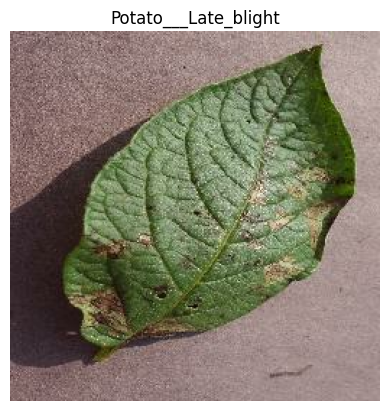

In [14]:
for image_batch, labels_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(str(class_names[labels_batch[0]]))
  plt.axis("off")

In [15]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  test_size = int(test_split * ds_size)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resizing_rescaling = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
    layers.Resizing(image_size, image_size),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [20]:
input_shape = (batch_size, image_size, image_size, 3)
n_classes = 3

model = models.Sequential([
    resizing_rescaling,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
hository =model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.5034 - loss: 0.9951 - val_accuracy: 0.6615 - val_loss: 0.8402
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7114 - loss: 0.7275 - val_accuracy: 0.8281 - val_loss: 0.4314
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8402 - loss: 0.4101 - val_accuracy: 0.8333 - val_loss: 0.4703
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8368 - loss: 0.3929 - val_accuracy: 0.8281 - val_loss: 0.3224
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8891 - loss: 0.2789 - val_accuracy: 0.9271 - val_loss: 0.1721
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9313 - loss: 0.1955 - val_accuracy: 0.9271 - val_loss: 0.1901
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9353 - loss: 0.1639 - val_accuracy: 0.9062 - val_loss: 0.2572
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9323 - loss: 0.1689 - val_accuracy: 0.9635 -

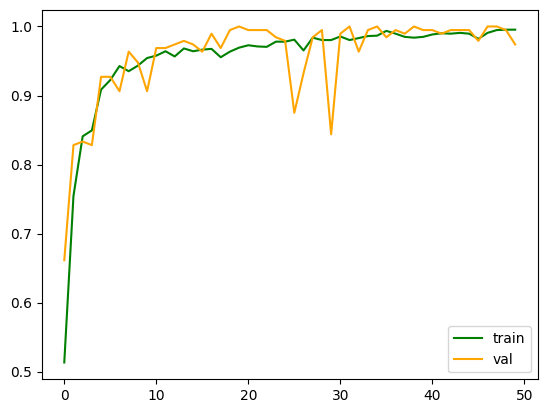

In [23]:
plt.plot(hository.history['accuracy'], color='green', label='train')
plt.plot(hository.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
predicted label: Potato___healthy


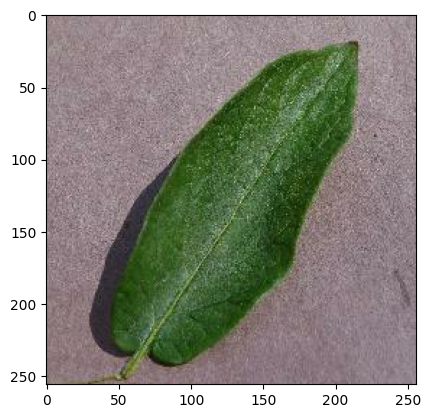

In [24]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])
  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[tf.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = class_names[tf.argmax(predictions[0])]
  # Convert the EagerTensor to a NumPy array before applying round
  confidence = round(100 * (tf.reduce_max(predictions[0]).numpy()), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


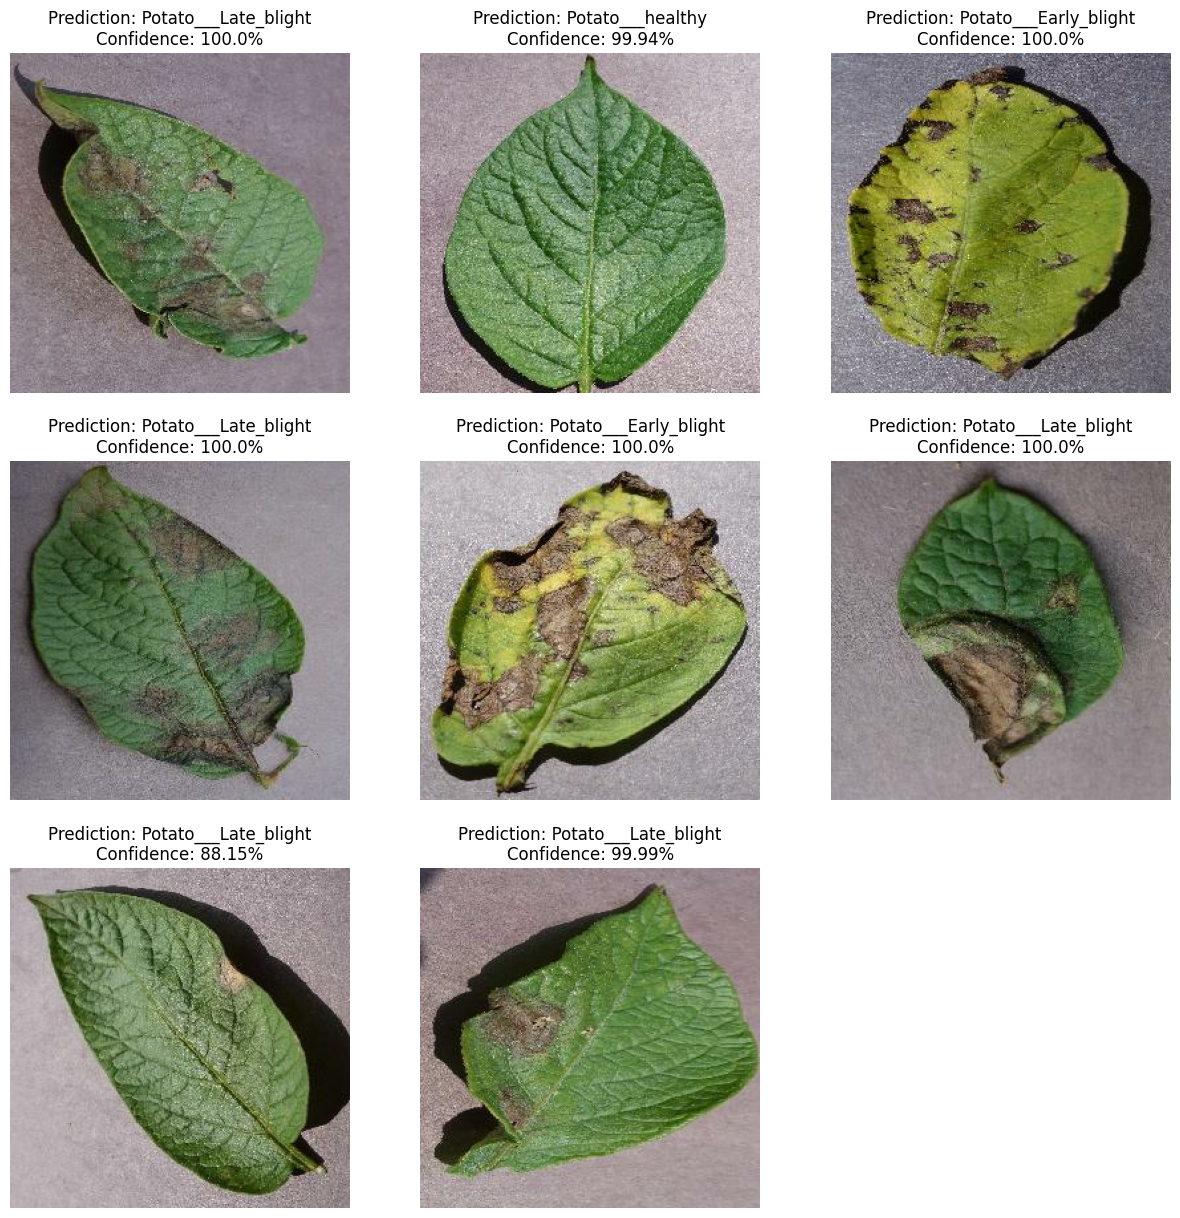

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence}%")

    plt.axis("off")

In [27]:
os.makedirs("saved_models", exist_ok=True)
model_version=1
model.save(f"saved_models/{model_version}.h5")